<a href="https://colab.research.google.com/github/yonghyuk0120/CNN_Study/blob/master/model/inception_v1(torch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                                                                ↑↑↑↑↑↑
                                        위의 Open in Colab 을 누르면 훨씬 가독성 있게 볼 수 있습니다.

# 1. 패키지 로드

In [ ]:
!pip install --upgrade albumentations

     |████████████████████████████████| 98 kB 5.1 MB/s 
     |████████████████████████████████| 37.1 MB 1.2 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import numpy as np
import pandas as pd
import cv2
import sklearn
import albumentations as A
import torch.nn as nn
import math
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from tqdm import tqdm
from torchsummary import summary
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from time import sleep


%matplotlib inline 

#device 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. 논문분석

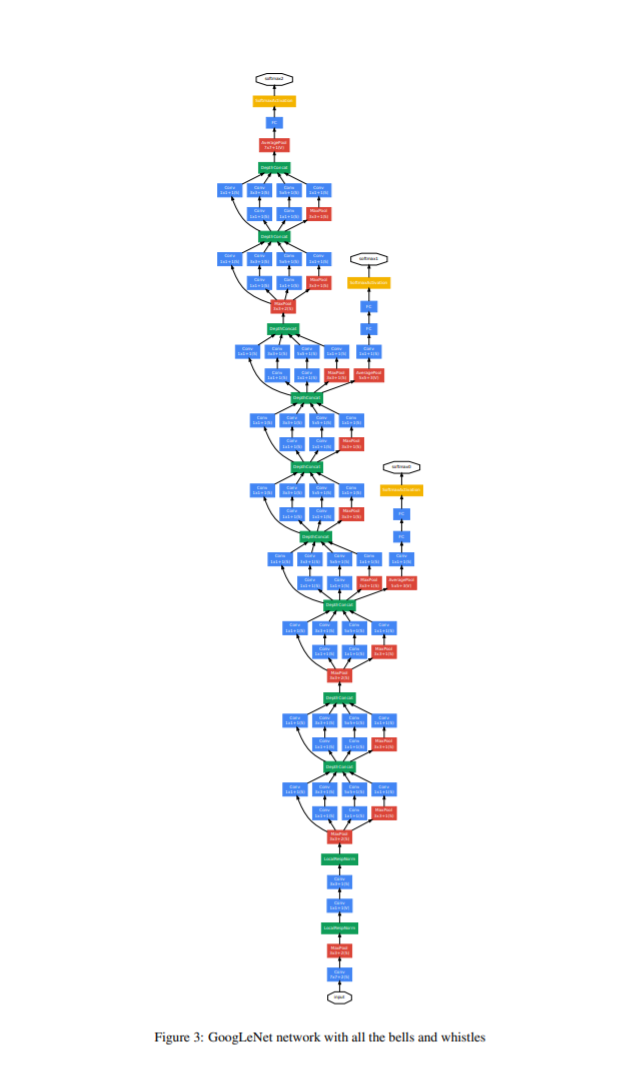

* Inception v1의 주요 특징은 위와 같은 인셉션 모듈이다. 이는, sparse한 구조와 dense한 연산과정을 적절하게 조합해낸 것.
* 좀 더 깊게 들어가보면, 실제 생물은 꽉 차있는 dense한 뉴런이 아니라 sparse하게 뉴런이 구조되어있으면, 어떠한 자극에 대해서 모든 뉴런이 반응하는 것이 아니라, 관련성이 높은 뉴런들끼리 Fire된다. 
* 그렇지만 sparse하게만 코드를 구성한다면, GPU연산의 장점인 dense한 병렬계산을 제대로 이용 할 수 없다. 파라미터 양은 실제로 줄어들지 몰라도 연산과정에서 시간이 오히려 더 들어간다.
* 이런 점들을 모방하기 위해 생각해 낸 아이디어가 위의 인셉션

* 여기서 1x1conv가 나오는데 이는 계산량, 채널수 조절 뿐만 아니라, relu를 거치게하여 비선형성을 추가하는데도 사용할 수 있음. + 비슷한 성질을 갖는 것끼리 묶어내는 역할
* Auxiliary classifier도 있는데 이는 나중 버전에서는 사라짐. 이것 또한 구현해보자.
* 모델 구현이 핵심이기에 이미지 사이즈, 데이터 증강, 가중치 초기화 등은 임의로 결정



# 3. 구현

## 기본구조 구현

In [ ]:
def conv_block(in_channels, out_channels, **kwargs) :
    """ 
    conv들이 기본적으로 ReLU를 가지고 있고,
    이번 논문에는 사용되지 않았지만,
    보통 성능향상을 위해서 BN층도 추가하여 block으로 만든다.
    대신 논문에 사용된 LRN층은 사용하지 않는다.
    BN을 사용하므로 bias는 False로 둔다.
    """
    output = nn.Sequential(
       nn.Conv2d(in_channels, out_channels, bias=False, **kwargs),
       nn.BatchNorm2d(out_channels),
       nn.ReLU()
    )
    return output


def conv3x3set(in_channels,reduce, out_channels) :
    """ 
    3x3conv + relu
    in_channels : in_channels
    reduce : reduce 채널
    out_channels : out_channels
    """
    output = nn.Sequential(
        conv_block(in_channels,reduce,kernel_size=1),
        conv_block(reduce,out_channels,kernel_size=3, padding = 'same')
    )
    return output

def conv5x5set(in_channels,reduce, out_channels) :
    """ 
    5x5conv + relu
    in_channels : in_channels
    reduce : reduce 채널
    out_channels : out_channels
    """
    output = nn.Sequential(
        conv_block(in_channels,reduce,kernel_size=1),
        conv_block(reduce,out_channels,kernel_size=5, padding = 'same')
    )
    return output



def pool_proj(in_channels, out_channels) :
    """
    maxpool + 1x1conv
    in_channels : in_channels
    out_channels : out_channels
    """
    output = nn.Sequential(
        nn.MaxPool2d(3, stride=1,  padding=1),
        conv_block(in_channels,out_channels,kernel_size=1)
    )
    return output

## 인셉션 모듈 구현


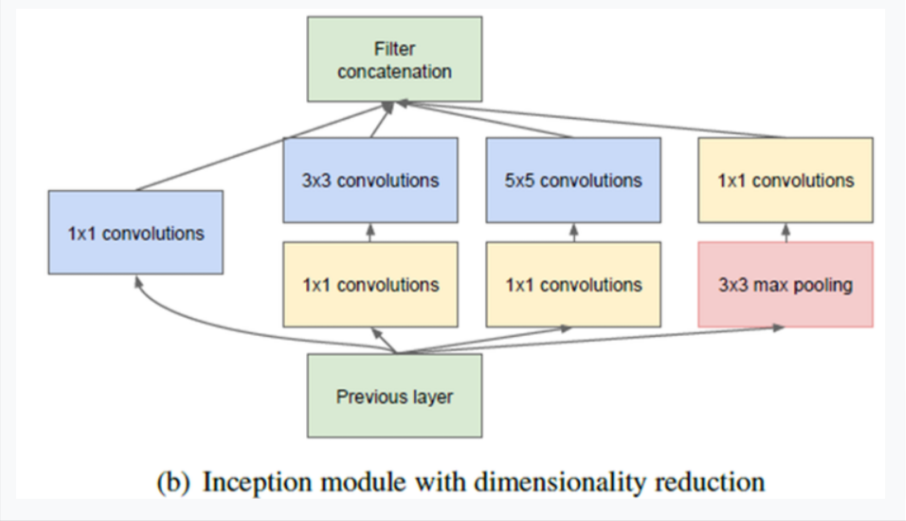

In [ ]:
class InceptionModule(nn.Module):
    """
    channels : [1x1, 3x3reduce, 3x3, 5x5reduce, 5x5, pool proj] 출력의 수를 리스트로 받아온다.(논문 표 대로)
    """
    def __init__(self, input_channels, channel_list):
        super(InceptionModule, self).__init__()

        self.output_channels = channel_list[0]+channel_list[2]+channel_list[4]+channel_list[5]

        self.conv1 = conv_block(input_channels,channel_list[0],kernel_size=1)

        self.conv2 = conv3x3set(input_channels,channel_list[1],channel_list[2])
        self.conv3 = conv5x5set(input_channels,channel_list[3],channel_list[4])
        self.proj = pool_proj(input_channels, channel_list[5])



    def forward(self, input_tensor):        
        path1 = self.conv1(input_tensor)
        path2 = self.conv2(input_tensor)
        path3 = self.conv3(input_tensor)
        path4 = self.proj(input_tensor)

        output  = [path1,path2,path3,path4]
        

        return torch.cat(output, 1)
    
    def get_output_channels(self):
        ''' 아웃풋 채널 수 반환'''
        return self.output_channels

       


model = InceptionModule(192,[64,96,128,16,32,32]).to(device)
summary(model, (192,28,28))
print(model)

model.get_output_channels()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]          12,288
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
            Conv2d-4           [-1, 96, 28, 28]          18,432
       BatchNorm2d-5           [-1, 96, 28, 28]             192
              ReLU-6           [-1, 96, 28, 28]               0
            Conv2d-7          [-1, 128, 28, 28]         110,592
       BatchNorm2d-8          [-1, 128, 28, 28]             256
              ReLU-9          [-1, 128, 28, 28]               0
           Conv2d-10           [-1, 16, 28, 28]           3,072
      BatchNorm2d-11           [-1, 16, 28, 28]              32
             ReLU-12           [-1, 16, 28, 28]               0
           Conv2d-13           [-1, 32, 28, 28]          12,800
      BatchNorm2d-14           [-1, 32,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


256

## auxiliary 구현
* vanishing gradient를 막아준다.(Rugularization효과)
* 오버피팅을 막아준다.

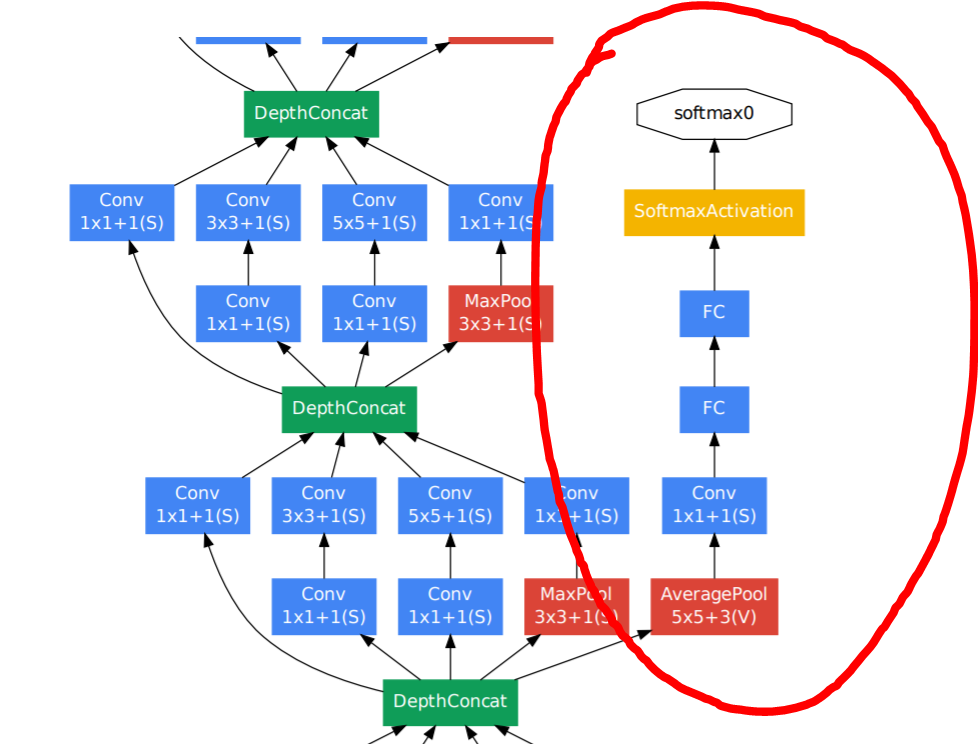

In [ ]:
class AuxiliaryModule(nn.Module):
    ''' resnet model을 만들어서 반환해준다'''
    def __init__(self, input_channels, num_classes=1000):
        super(AuxiliaryModule, self).__init__()        
        
        self.auxi_module = nn.Sequential(
            # 5x5 + 3(V) avgpool
            nn.AvgPool2d(5,3),
            
            # 1x1 + 1(S) conv
            conv_block(input_channels,128,kernel_size=1),

            # FC
            nn.Flatten(),
            nn.Linear(2048,1024),
            nn.ReLU(),

            # 0.7 dropout
            nn.Dropout(0.7),

            #FC
            nn.Linear(1024, num_classes)

            #nn.Softmax()

            # 원래는 소프트 맥스가 있지만, 우리는 loss로 crossentropy를 사용할 것이기에 생략
            # crossentropy에 softmax가 포함되어있다.
        )


    def forward(self, input_tensor):
        return self.auxi_module(input_tensor)




## GoogleNet 구현

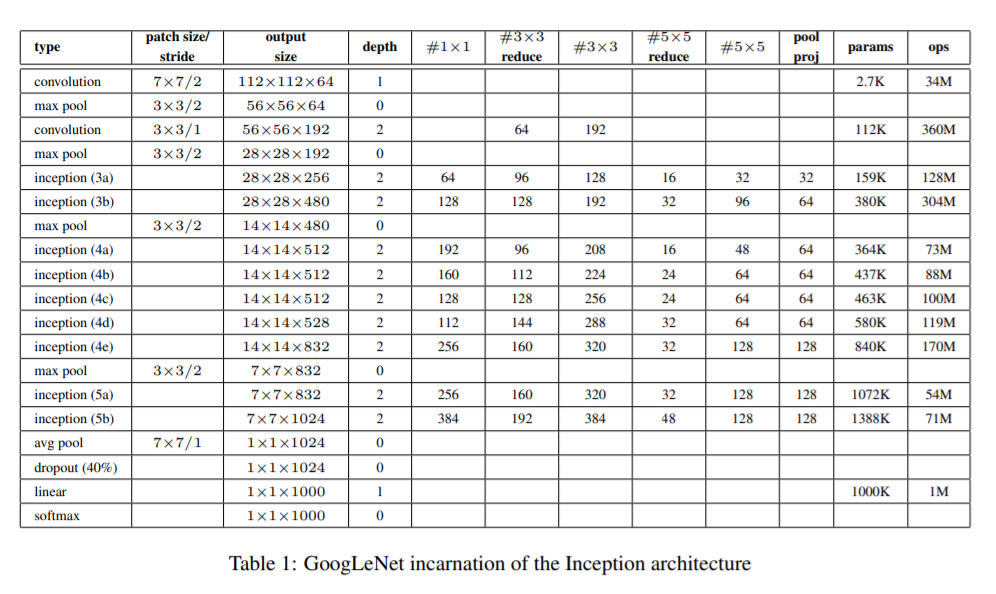

In [ ]:
class GoogleNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(GoogleNet, self).__init__()

        # 시작 부분  output (192,28,28)
        self.bottom  = nn.Sequential(
            conv_block(3,64,kernel_size=7, stride = 2, padding = 3),
            nn.MaxPool2d(3,2,1),
            conv_block(64, 64, kernel_size=1),
            conv_block(64, 192, kernel_size=3, padding=1),
            nn.MaxPool2d(3,2,1)
        )
        
        self.inception_3a = InceptionModule(192,[64,96,128,16,32,32])
        self.inception_3b = InceptionModule(256,[128,128,192,32,96,64])
        self.maxpool1 = nn.MaxPool2d(3,2,1)

        self.inception_4a = InceptionModule(480, [192, 96, 208, 16, 48, 64])
        self.inception_4b = InceptionModule(512, [160, 112, 224, 24, 64, 64])
        self.inception_4c = InceptionModule(512, [128, 128, 256, 24, 64, 64])
        self.inception_4d = InceptionModule(512, [112, 144, 288, 32, 64, 64])
        self.inception_4e = InceptionModule(528, [256, 160, 320, 32, 128, 128])
        self.maxpool2 = nn.MaxPool2d(3,2,1)

        self.inception_5a = InceptionModule(832,[256, 160, 320, 32, 128, 128])
        self.inception_5b = InceptionModule(832, [384, 192, 384, 48, 128, 128])

        self.gap =  nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

        self.aux1 = AuxiliaryModule(512, num_classes)
        self.aux2 = AuxiliaryModule(528, num_classes)


        self._initialize_weights()


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                              

    def forward(self, input_tensor):


        x = self.bottom(input_tensor)

        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.maxpool1(x)

        x = self.inception_4a(x)

        if self.training:
            aux1 = self.aux1(x)
        
        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)

        if self.training:
            aux2 = self.aux2(x)
        
        x = self.inception_4e(x)
        x = self.maxpool2(x)

        x = self.inception_5a(x)
        x = self.inception_5b(x)

        x = self.gap(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)

        if self.training:
            return x, aux1, aux2
        else:
            return x 







In [ ]:
model = GoogleNet().to(device)
summary(model, (3, 224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
             ReLU-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
             ReLU-14           [-1, 64,

# 4. 데이터 전처리

## 데이터 로드
 * 이미지 채크
 * STL10 (3,96,96)의 토치형식


In [ ]:
trainset = torchvision.datasets.STL10(root='./data', split='test',
                                        download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.STL10(root='./data', split='train',
                                       download=True, transform= transforms.ToTensor())

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [ ]:
print(len(trainset))
print(len(testset))

8000
5000


In [ ]:
classes = trainset.classes

In [ ]:
batch_size = 7
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
classes = trainset.classes
# 클래스 정보 가져오기

In [ ]:
# trainloader.

In [ ]:
# 이미지를 보여주기 위한 함수
def show_images(images, labels, ncols=4):
    figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(np.transpose(images[i], (1, 2, 0)))
        # 차원이 바뀌므로 바꿔줘야함
        axs[i].set_title(classes[labels[i]])

In [ ]:
# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

(3, 96, 96)
torch.Size([3, 96, 96])


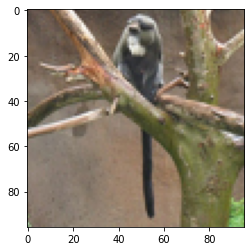

In [ ]:
# 잘 들어왔나 확인
# plt.imshow(trainset.data[1])
# STL은 애초에 데이터셋 자체가 텐서형식임((3, 96, 96))
# Totensor(데이터 로더를 통해)하면 알아서 차원까지 transpose해줌.
# cifar 경우 32 32 3 임. plt가 32,32,3 으로 받기 때문에 plt 통해 출력하려면 transpose가 필요
plt.imshow(np.transpose(trainset.data[1], (1, 2, 0)))

print(trainset.data[1].shape)
print(images[1].shape)

In [ ]:
print(trainset.data[1][1,:3,0:3])
print(images[1][1,:3,0:3])
print(transforms.ToTensor()(trainset.data[1]/255)[1,:3,0:3])
print(transforms.ToTensor()(trainset.data[1])[1,:3,0:3])
# trainloader의 trasform을 거치는 것 만으로 0~1로 정규화된다.
# 아래 transform에서 평균과 표준편차로 나누는 것은 정확히는 표준화이다.
# totensor를 거치면 자동으로 0~1로 정규화 된다. 그리고 totensor 안에 transpose도 들어있는듯
# totensor안에 정규화가 들어있는데, 값이 이미 정규화되어있으면 하지 않음. 3,4번 라인비교


[[73 81 89]
 [71 79 86]
 [64 77 80]]
tensor([[0.2863, 0.3176, 0.3490],
        [0.2784, 0.3098, 0.3373],
        [0.2510, 0.3020, 0.3137]])
tensor([[0.3922, 0.3608, 0.3373],
        [0.3176, 0.3098, 0.3020],
        [0.2980, 0.2824, 0.2667]], dtype=torch.float64)
tensor([[0.3922, 0.3608, 0.3373],
        [0.3176, 0.3098, 0.3020],
        [0.2980, 0.2824, 0.2667]])


In [ ]:
# 아래처럼, loader안에 transpose 후 totensor하면 원하던 차원순서 312가 나옴
testnp = np.zeros((3,1,2))
print(testnp.shape)
print(transforms.ToTensor()(testnp).shape)
print(np.transpose(testnp, (1, 2, 0)).shape)
print(transforms.ToTensor()(np.transpose(testnp, (1, 2, 0))).shape)

(3, 1, 2)
torch.Size([2, 3, 1])
(1, 2, 3)
torch.Size([3, 1, 2])


In [ ]:
print(trainset.data[1].shape)
print(images[1].shape)
print(transforms.ToTensor()(trainset.data[1]).shape)

#????? totansor뿐만아니라 loader까지 거쳐야 원하는 차원으로 나오는듯
# 아마 로더에 차원 변경이 구현되어있는듯
# 아래 커스텀 모델에 이것도 구현해야함.

(3, 96, 96)
torch.Size([3, 96, 96])
torch.Size([96, 3, 96])


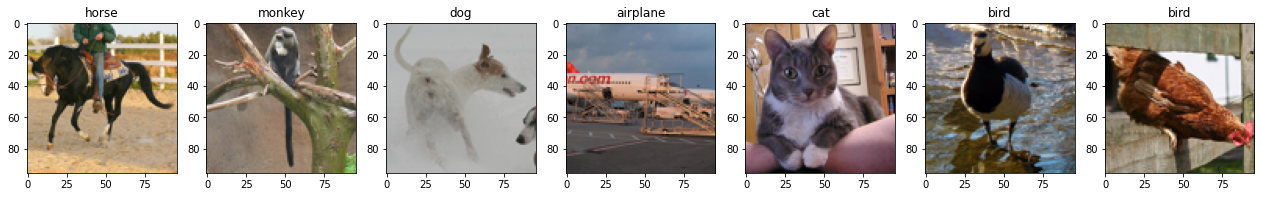

In [ ]:
# 이미지 보여주기
show_images(images,labels,7)

In [ ]:
images[1][1,1,1]

tensor(0.3098)

In [ ]:
aa = np.transpose(trainset.data[1], (1, 2, 0))
print(transforms.ToTensor()(aa).shape)

torch.Size([3, 96, 96])


## 커스텀 데이터셋 구현
* albumentations을 사용하기 위해서 커스텀 데이터 셋을 구현한다.
* 파이토치 텐서플로우 전부 이미지를 배치단위로 cpu,gpu 옮기는 과정에 병목이 있다고 알고있음. 즉, tf나 torch나 데이터 파이프 라인을 그대로 쓰는 것 보다 albumentations을 이용하는 것이 훨씬빠름.




In [ ]:
# 커스텀 데이터(albumenatation 적용)
class ForAlbuSet(Dataset):
    def __init__(self, dataset, transform = None ,data_type = "train" ):
        self.dataset = dataset
        self.transform = transform
        self.data_type = data_type


    def __len__(self):
        return self.dataset.data.shape[0]

    def __getitem__(self, index):
        image = self.dataset.data[index]
        image = np.transpose(image, (1, 2, 0))
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 위옵션은 cv2.imread에서 필요함
        label = self.dataset.labels[index]
        # CIFAR에서는 데이터셋 안에 label이 아니라 target으로 적혀있음.
        # CIFAR는 int반환이지만 얘는 numpy.unit8
        # label과 image를 output 결과와 통일 시켜야함(int,long, float, double 등등)
        # 형변환은 train에서 구현 : 데이터셋과 상관없이 항상 필요한 작업

        
        if self.data_type == "train" : 
            # random_n = np.random.randint(148,256)
            # image = cv2.resize(image, (random_n,random_n))
            # resize로 멀티스케일을 작게나마 구현 해보았음
            # 다만 너무 계산시간이 커진다.

            if self.transform is not None:
                image = self.transform(image=image)["image"]        
        else :

            if self.transform is not None:
                image = self.transform(image=image)["image"]


        return image, label
    

## 증강(transform)

* 토치의 transform 사용시에는 to 텐서 다음에 노말 하기. totensor를 해야 값들이 0\~1사이로감. 그래야 imagenet 평균과 표준편차를 사용가능(0\~255가 아니라 0~1이니까)
    > albumentation은 구현코드를 확인해보면, normalize안에 자동으로 255로 나눠서 구현되어있음.


* torchvision.transforms.(채널, 세로, 가로) 과 달리 Albu.transforms 는 array 기준으로 작업함(세로,가로,채널)
* cv2는 (가로,세로,채널)

* (주의) totensor없으면 loader가 작동 안 함.(차원 순서 바뀌기 때문)

* 실험과정에서 성능이 좋지않아서 논문과 다른 장치들을 넣었음.

In [ ]:
augmentor_tr = A.Compose([        
    # A.Resize(232,232),
    A.Resize(224,224),                
    # A.FancyPCA(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.ShiftScaleRotate(scale_limit=(0.7, 0.9), p=0.5, rotate_limit=30),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5),
    A.Blur(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

augmentor_test = A.Compose([
    A.Resize(224,224),                            
    A.Normalize(),
    ToTensorV2()
])

## 분할

* random_split이 Torch.utils.data.dataset.random_split에도 있는데, 이건 제대로 작동 안 하니까 조심, random_split은 분할을 하지만 원본을 그대로 두고 랜덤인덱스로 불러오는 원리.아마 메모리 관리를 위해 이렇게 구현한듯

* STL10 데이터는 테스트가 8000개고 트레인이 5000개 이다. 테스트가 트레인보다 많으므로, test데이터로 train에쓰고 train 데이터로 테스트에 쓰자. 트레인 데이터가 더 많아야 한다. 
    > 위의 로딩식 수정했음. 
    
* 또한 분할을 이용해서 5000개를 3000/2000으로 나누어 validation과 test를 하자.

In [ ]:
val_ratio = 0.6
val_size = round(len(testset)*val_ratio)
test_size = len(testset) - val_size
                    
val_set, test_set= random_split(
    testset,
    [val_size,test_size],
    generator=torch.Generator().manual_seed(20)
    )

In [ ]:
# 분할 채크
len(val_set)

3000

In [ ]:
ab_train_set = ForAlbuSet(trainset, transform=augmentor_tr)
ab_val_set = ForAlbuSet(val_set.dataset, transform=augmentor_test, data_type= 'val')
ab_test_set = ForAlbuSet(test_set.dataset, transform=augmentor_test, data_type= 'test')


In [ ]:
batch_size = 64
train_loader = DataLoader(ab_train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
val_loader = DataLoader(ab_val_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

test_loader = DataLoader(ab_test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)




In [ ]:
augmentor_tr = A.Compose([        
    # A.Resize(232,232),
    A.Resize(224,224),                
    # A.FancyPCA(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.ShiftScaleRotate(scale_limit=(0.7, 0.9), p=0.5, rotate_limit=30),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5),
    A.Blur(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

augmentor_test = A.Compose([
    A.Resize(224,224),                            
    A.Normalize(),
    ToTensorV2()
])

# 5. 학습 및 평가

**구현목표**
* 정확도 metric 구현 
* 로스, 정확도 동시에 출력
* 콜백(reducelr, earlystop)
* 작업진행도 모니터링 출력
* 테스트 loss 변화 그래프로 출력
* train, vaildate, fit 구현



## early stopping class 정의

In [ ]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0

        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).')

        self.val_loss_min = val_loss

## train, validate, fit, test 함수 정의

In [ ]:
def train(model,train_loader, criterion, optimizer, epoch):
    model.train()
    stream = tqdm(train_loader)
    train_loss = 0
    correct = 0

    for images, target in stream:
        images = images.to(device).float()
        target = target.to(device).long()
        optimizer.zero_grad()

        # criterion 에 mean옵션(default)를 주면 되지만 sum을 이용한 loss 합이 필요함.(출력위해서)
        
        # 이상하게 sum옵션으로 하면 학습이 되지 않음. 수동으로 mean 구현하고 lossfunc은 sum이용.
        # 일반 학습과 달리 auxi 블럭을 추가했기 때문에 이 부분에서 output이 3갈래로나옴.
        output, aux1, aux2 = model(images)
        sum_output_loss = criterion(output, target)
        sum_aux1_loss = criterion(aux1, target)
        sum_aux2_loss = criterion(aux2, target)

        # 논문에서 aux는 weight를 가진다고 제시함.
        sum_loss = sum_output_loss + 0.3*(sum_aux1_loss + sum_aux2_loss)

        
        loss = sum_loss/len(target)        
     


        loss.backward()
        optimizer.step()

        # 로스합
        train_loss +=sum_loss.item()

        # 정확도 계산
        pred = output.max(dim = 1,keepdim = True)[1]
        correct += (target.view(-1, 1) == pred).sum().item()


        stream.set_description(
            f"Epoch: {epoch}. Train."
        )
        

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)

    return train_loss, train_accuracy

In [ ]:
def validate(model, val_loader, criterion, epoch):
    model.eval()
    stream = tqdm(val_loader)
    val_loss = 0
    correct = 0

    with torch.no_grad():
        for images, target in stream:
            images = images.to(device).float()
            target = target.to(device).long()

            output = model(images)
            sum_loss = criterion(output, target)
            loss = sum_loss/len(target)
            # criterion 에 mean옵션(default)를 주면 되지만 sum을 이용한 loss 합이 필요함.(출력위해서)
            # 이상하게 sum옵션으로 하면 학습이 되지 않음. 수동으로 mean 구현하고 sum이용.

            # 로스합
            val_loss +=sum_loss.item()

            # 정확도 계산
            pred = output.max(dim = 1,keepdim = True)[1]
            correct += (target.view(-1, 1) == pred).sum().item()




            stream.set_description(
                f"Epoch: {epoch}. Validate."
            )
    val_loss /= len(val_loader.dataset)
    val_accuracy = 100. * correct / len(val_loader.dataset)

    return val_loss, val_accuracy

In [ ]:
def fit(model,train_loader,val_loader,criterion,optimizer,epoch, early_stopping=None, scheduler=None):
 
    # epoch당 average loss를 track하기 위한 list
    avg_train_losses = []
    avg_val_losses = []

    for i in range(1, epoch + 1):
        train_loss ,train_accuracy =train( model,train_loader, criterion, optimizer, i)
        print(f"[{i}] Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
        val_loss ,val_accuracy = validate( model,val_loader, criterion, i)
        if i == epoch :
            sleep(0.1)
            # 마지막 출력에서 tqdm이 업데이트 되기전에 아래 출력값이 나오지 않도록.
            # 다른 줄에 아래값이 나올 수 있게 해줌
        print(f"[{i}] Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")


        
        if scheduler is not None :
            # scheduler.step()
            scheduler.step(val_loss) 
            # 아래는 reducelronplateau 전용
            

        avg_train_losses.append(train_loss)
        avg_val_losses.append(val_loss)

        
        if early_stopping is not None :
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print()
                print("Early stopping")
                sleep(0.1)
                break

        print()

                         
    return  model, avg_train_losses, avg_val_losses


In [ ]:
def test(model, test_loader, criterion):
    test_loss ,test_accuracy = validate( model,test_loader, criterion, 1)
    sleep(0.1)
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")
    
    return (test_loss ,test_accuracy)

## 학습

In [ ]:
model = GoogleNet(10).to(device)

In [ ]:
# loss function의 정의(CrossEntropyLoss)
criterion = nn.CrossEntropyLoss(reduction='sum')

# optimizer 정의
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# 스케쥴러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,verbose=True)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


# early_stopping
early_stopping = EarlyStopping(patience = 15, verbose = True)

In [ ]:
model, train_loss, val_loss = fit(model,train_loader,val_loader,criterion,optimizer,100,early_stopping,scheduler)

Epoch: 1. Train.: 100%|██████████| 125/125 [00:33<00:00,  3.76it/s]


[1] Train Loss: 3.1698, Accuracy: 25.25%


Epoch: 1. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.07it/s]


[1] Validation Loss: 1.6898, Accuracy: 36.60%
Validation loss decreased (inf --> 1.689846).



Epoch: 2. Train.: 100%|██████████| 125/125 [00:33<00:00,  3.74it/s]


[2] Train Loss: 2.7238, Accuracy: 36.17%


Epoch: 2. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.18it/s]


[2] Validation Loss: 1.5334, Accuracy: 41.96%
Validation loss decreased (1.689846 --> 1.533364).



Epoch: 3. Train.: 100%|██████████| 125/125 [00:33<00:00,  3.68it/s]


[3] Train Loss: 2.5058, Accuracy: 41.60%


Epoch: 3. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.10it/s]


[3] Validation Loss: 1.4570, Accuracy: 45.72%
Validation loss decreased (1.533364 --> 1.456956).



Epoch: 4. Train.: 100%|██████████| 125/125 [00:34<00:00,  3.65it/s]


[4] Train Loss: 2.3687, Accuracy: 45.90%


Epoch: 4. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.96it/s]


[4] Validation Loss: 1.3833, Accuracy: 48.84%
Validation loss decreased (1.456956 --> 1.383306).



Epoch: 5. Train.: 100%|██████████| 125/125 [00:34<00:00,  3.64it/s]


[5] Train Loss: 2.2876, Accuracy: 47.52%


Epoch: 5. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.92it/s]


[5] Validation Loss: 1.3056, Accuracy: 51.20%
Validation loss decreased (1.383306 --> 1.305585).



Epoch: 6. Train.: 100%|██████████| 125/125 [00:34<00:00,  3.61it/s]


[6] Train Loss: 2.1936, Accuracy: 49.83%


Epoch: 6. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.07it/s]


[6] Validation Loss: 1.2655, Accuracy: 53.52%
Validation loss decreased (1.305585 --> 1.265504).



Epoch: 7. Train.: 100%|██████████| 125/125 [00:34<00:00,  3.60it/s]


[7] Train Loss: 2.1238, Accuracy: 52.58%


Epoch: 7. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.89it/s]


[7] Validation Loss: 1.1777, Accuracy: 55.56%
Validation loss decreased (1.265504 --> 1.177700).



Epoch: 8. Train.: 100%|██████████| 125/125 [00:34<00:00,  3.60it/s]


[8] Train Loss: 2.0651, Accuracy: 53.64%


Epoch: 8. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.96it/s]


[8] Validation Loss: 1.1770, Accuracy: 56.44%
Validation loss decreased (1.177700 --> 1.177020).



Epoch: 9. Train.: 100%|██████████| 125/125 [00:34<00:00,  3.60it/s]


[9] Train Loss: 2.0122, Accuracy: 55.16%


Epoch: 9. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.02it/s]


[9] Validation Loss: 1.3401, Accuracy: 51.64%
EarlyStopping counter: 1 out of 15



Epoch: 10. Train.: 100%|██████████| 125/125 [00:34<00:00,  3.58it/s]


[10] Train Loss: 1.9571, Accuracy: 56.66%


Epoch: 10. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.85it/s]


[10] Validation Loss: 1.1343, Accuracy: 58.32%
Validation loss decreased (1.177020 --> 1.134303).



Epoch: 11. Train.: 100%|██████████| 125/125 [00:34<00:00,  3.59it/s]


[11] Train Loss: 1.8890, Accuracy: 58.08%


Epoch: 11. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.10it/s]


[11] Validation Loss: 1.0724, Accuracy: 61.46%
Validation loss decreased (1.134303 --> 1.072403).



Epoch: 12. Train.: 100%|██████████| 125/125 [00:34<00:00,  3.58it/s]


[12] Train Loss: 1.8504, Accuracy: 58.80%


Epoch: 12. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.09it/s]


[12] Validation Loss: 1.1198, Accuracy: 59.02%
EarlyStopping counter: 1 out of 15



Epoch: 13. Train.: 100%|██████████| 125/125 [00:34<00:00,  3.59it/s]


[13] Train Loss: 1.8136, Accuracy: 59.74%


Epoch: 13. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.97it/s]


[13] Validation Loss: 1.1802, Accuracy: 59.18%
EarlyStopping counter: 2 out of 15



Epoch: 14. Train.: 100%|██████████| 125/125 [00:34<00:00,  3.59it/s]


[14] Train Loss: 1.7842, Accuracy: 60.29%


Epoch: 14. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.13it/s]


[14] Validation Loss: 0.9648, Accuracy: 65.70%
Validation loss decreased (1.072403 --> 0.964796).



Epoch: 15. Train.: 100%|██████████| 125/125 [00:34<00:00,  3.58it/s]


[15] Train Loss: 1.7293, Accuracy: 62.04%


Epoch: 15. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.14it/s]


[15] Validation Loss: 1.0335, Accuracy: 62.34%
EarlyStopping counter: 1 out of 15



Epoch: 16. Train.: 100%|██████████| 125/125 [00:34<00:00,  3.59it/s]


[16] Train Loss: 1.7119, Accuracy: 62.54%


Epoch: 16. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.17it/s]


[16] Validation Loss: 1.0870, Accuracy: 60.58%
EarlyStopping counter: 2 out of 15



Epoch: 17. Train.: 100%|██████████| 125/125 [00:35<00:00,  3.57it/s]


[17] Train Loss: 1.6931, Accuracy: 62.44%


Epoch: 17. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.20it/s]


[17] Validation Loss: 0.9509, Accuracy: 66.72%
Validation loss decreased (0.964796 --> 0.950924).



Epoch: 18. Train.: 100%|██████████| 125/125 [00:34<00:00,  3.60it/s]


[18] Train Loss: 1.6319, Accuracy: 64.50%


Epoch: 18. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.01it/s]


[18] Validation Loss: 1.0181, Accuracy: 64.12%
EarlyStopping counter: 1 out of 15



Epoch: 19. Train.: 100%|██████████| 125/125 [00:34<00:00,  3.60it/s]


[19] Train Loss: 1.6124, Accuracy: 64.91%


Epoch: 19. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.94it/s]


[19] Validation Loss: 1.0239, Accuracy: 62.90%
EarlyStopping counter: 2 out of 15



Epoch: 20. Train.: 100%|██████████| 125/125 [00:34<00:00,  3.58it/s]


[20] Train Loss: 1.6010, Accuracy: 65.06%


Epoch: 20. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.87it/s]


[20] Validation Loss: 1.0644, Accuracy: 63.12%
EarlyStopping counter: 3 out of 15



Epoch: 21. Train.: 100%|██████████| 125/125 [00:34<00:00,  3.59it/s]


[21] Train Loss: 1.5549, Accuracy: 66.29%


Epoch: 21. Validate.: 100%|██████████| 79/79 [00:08<00:00,  9.01it/s]


[21] Validation Loss: 1.1139, Accuracy: 61.90%
EarlyStopping counter: 4 out of 15



Epoch: 22. Train.: 100%|██████████| 125/125 [00:34<00:00,  3.58it/s]


[22] Train Loss: 1.5305, Accuracy: 66.96%


Epoch: 22. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.94it/s]


[22] Validation Loss: 0.9372, Accuracy: 67.32%
Validation loss decreased (0.950924 --> 0.937188).



Epoch: 23. Train.: 100%|██████████| 125/125 [00:34<00:00,  3.59it/s]


[23] Train Loss: 1.5112, Accuracy: 67.71%


Epoch: 23. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.89it/s]


[23] Validation Loss: 0.9293, Accuracy: 67.54%
Validation loss decreased (0.937188 --> 0.929277).



Epoch: 24. Train.: 100%|██████████| 125/125 [00:34<00:00,  3.58it/s]


[24] Train Loss: 1.4855, Accuracy: 68.16%


Epoch: 24. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.93it/s]


[24] Validation Loss: 0.9090, Accuracy: 67.56%
Validation loss decreased (0.929277 --> 0.908957).



Epoch: 25. Train.: 100%|██████████| 125/125 [00:34<00:00,  3.58it/s]


[25] Train Loss: 1.4901, Accuracy: 67.54%


Epoch: 25. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.91it/s]


[25] Validation Loss: 0.9523, Accuracy: 67.24%
EarlyStopping counter: 1 out of 15



Epoch: 26. Train.: 100%|██████████| 125/125 [00:34<00:00,  3.58it/s]


[26] Train Loss: 1.4086, Accuracy: 69.79%


Epoch: 26. Validate.: 100%|██████████| 79/79 [00:09<00:00,  8.75it/s]


[26] Validation Loss: 0.9661, Accuracy: 67.02%
EarlyStopping counter: 2 out of 15



Epoch: 27. Train.: 100%|██████████| 125/125 [00:34<00:00,  3.59it/s]


[27] Train Loss: 1.4015, Accuracy: 70.65%


Epoch: 27. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.86it/s]


[27] Validation Loss: 0.9441, Accuracy: 67.66%
EarlyStopping counter: 3 out of 15



Epoch: 28. Train.: 100%|██████████| 125/125 [00:35<00:00,  3.57it/s]


[28] Train Loss: 1.4109, Accuracy: 69.79%


Epoch: 28. Validate.: 100%|██████████| 79/79 [00:08<00:00,  8.85it/s]


[28] Validation Loss: 0.9534, Accuracy: 67.72%
EarlyStopping counter: 4 out of 15



Epoch: 29. Train.: 100%|██████████| 125/125 [00:34<00:00,  3.59it/s]


[29] Train Loss: 1.3765, Accuracy: 70.84%


Epoch: 29. Validate.: 100%|██████████| 79/79 [00:09<00:00,  8.61it/s]


[29] Validation Loss: 0.9152, Accuracy: 68.48%
EarlyStopping counter: 5 out of 15



Epoch: 30. Train.: 100%|██████████| 125/125 [00:35<00:00,  3.56it/s]


[30] Train Loss: 1.3581, Accuracy: 71.05%


Epoch: 30. Validate.: 100%|██████████| 79/79 [00:09<00:00,  8.75it/s]


[30] Validation Loss: 0.8360, Accuracy: 71.10%
Validation loss decreased (0.908957 --> 0.835963).



Epoch: 31. Train.: 100%|██████████| 125/125 [00:35<00:00,  3.56it/s]


[31] Train Loss: 1.3288, Accuracy: 72.21%


Epoch: 31. Validate.: 100%|██████████| 79/79 [00:09<00:00,  8.52it/s]


[31] Validation Loss: 0.9651, Accuracy: 68.22%
EarlyStopping counter: 1 out of 15



Epoch: 32. Train.:  14%|█▍        | 18/125 [00:05<00:33,  3.15it/s]


KeyboardInterrupt: ignored

## 평가

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(val_loss)+1),val_loss,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = val_loss.index(min(val_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 5) # 일정한 scale
plt.xlim(0, len(train_loss)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches = 'tight')

In [ ]:
test(model, test_loader, criterion)

## 러닝 레이트 관해서 
러닝레이트를 조절하면서 학습시켜보니까 
0.1시작 할 때는 아무리 학습해도 제자리이지만, 
0.001로시작하니까 10epoch도 안 지났는데, 순식간에 오른다.

아마 이게 loss함수 옵션에 sum, mean이랑도 관련 있을듯. 다른 사람 구현 코드에서는 mean(디폴트)가 먹힐 때 도 있고, 그대로 옮겨서 (sum)하면 안 먹힐 때도 있는데, 그라디언트 값 자체가 달라지니까. 아마 sum옵션에 맞는 rate가 있고 mean옵션에 맞는 rate가 있는 듯. 

혹은 그냥 0.0001이 대부분 좋을 수도. TF는 대부분 그냥 잘 되었는데 torch는 옵션이 많아서 복잡하다.